<a href="https://colab.research.google.com/github/CabeludoCego/SistEvolutivos/blob/main/Enviado_AAC6_(NSGA_II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as U
import math
import time

# Funções: Min-Ex versão NSGA-II


In [ ]:
def f1(x1):
  return x1

def f2(x1,x2):
  return ((1+x2)/x1)

def fitnessMO(vt_real, Fit, pop):
  for i in range(pop):
    Fit[i,0] = f1(vt_real[i][0])
    Fit[i,1] = f2(vt_real[i][0], vt_real[i][1])

def Dominando(Fit, vRank, pop):
  for i in range(pop):
    Fi1 = Fit[i,0]
    Fi2 = Fit[i,1]
    ni = 0
    for k in range(pop):
      if ((Fi1) > Fit[k,0]):    # Se é pior que um objetivo E
        if ((Fi2) > Fit[k,1]):  # Se é pior que o segundo objetivo
          ni += 1             # É dominada
    vRank[i] = ni + 1         # Atribui um rank


def Fdist(x,y, xmax, xmin):
  d = 0
  a = 0
  for i in range(nx):
    a += ( ( (x[i] - y[i])/(xmax[i] - xmin[i]) )**2)
  d = np.sqrt(a)
  return d

def nicho(d, alfaShare, alfa):
  if d <= alfaShare:
    f = 1 - (d/alfaShare)**alfa
  else:
    f = 0
  return f

In [ ]:
def sortir(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido

def sortirMaior(vetor, vetorIndices, elementos):
  indices = (np.argsort(vetorIndices, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return vetorSortido[::-1]

def sortirFit(crowdFit, Len, m):
  indices = (np.argsort(crowdFit[:,m], axis=0))
  cF = np.copy(crowdFit)
  for i in range(Len):
    cF[i] = crowdFit[int(indices[i])]
  return cF

def sortirMaior2(vetor, elementos):
  indices = (np.argsort(vetor, axis=0))
  n = len(vetor[0])
  vetorSortido = np.zeros((elementos,n))
  i = 0
  while i < elementos:
    vetorSortido[i] = vetor[int(indices[i])]
    i = i + 1
  return [vetorSortido[::-1], indices[::-1]]

In [ ]:
# Etapa 3: Obter número total de ranks
def rankMembers(vRank_s):
  r_count = []    # Se não existe no vetor, anexa a ele
  for i in vRank_s:
    if (i not in r_count): r_count.append(i)  

  numRanks = len(r_count)

  memberCount = np.zeros((numRanks,2), dtype=int)

  Elem_contados = []
  n = 0
  for i in vRank_s:
    if i not in Elem_contados:
      Elem_contados.append(i)  # Anexado à lista de ranks únicos
      memberCount[n,0] = i
      memberCount[n,1] = list(vRank_s).count(i)
      n += 1

  return memberCount

In [ ]:
def bin2real(b, xmin, xmax):
  # Conversão de inteiro para binário
  s = 0
  n = len(b)        # [s1,l] => Pega a dimensão 2
  for l in range(n):
    s = s + b[l]*pow(2,l)
  return xmin + (xmax - xmin)*s/(pow(2,n)-1)

In [ ]:
# Criar divisor de bits a serem usados!
def xj_range(bits, nx):
  limites_xj = np.zeros((2,nx), dtype=int)
  cont = 0
  ik = bits
  while ik <= (bits*nx):
    
    if ((ik) % bits == 0):    # Se ik for divisível por 20
      
      limites_xj[1,cont] = ik-1  # Atribui ub: 20, 40, 60, 80 (-1)
      cont = cont + 1            # incrementa
      if (cont < nx):
        limites_xj[0,cont] = ik # Atribui lb: 20, 40, 60 (-1)
      
    ik = ik + 1
  return limites_xj

In [ ]:
xj_range(20, 4)

array([[ 0, 20, 40, 60],
       [19, 39, 59, 79]])

In [ ]:
# Dividir X em nx parcelas de acordo com o limite em Xj_range
# Supondo X = vt[i,:]

def xj_divide(X, bits, nx):
  limites = xj_range(bits,nx)

  Xt = np.zeros((nx,bits), dtype=int)
  i = 0
  for i in range (nx):
    Xt[i,:] = X[limites[0,i]:(limites[1,i]+1)]
                                    # -> [0:19], python pega do 0 ao 18.
                                    # O +1 resolve o problema
  return Xt

In [ ]:
def criarpop(vetor, pop, cromo):
  i = 0
  for i in range(pop):                 # Cria-se uma linha(indivíduo) por vez
    n = (np.random.rand(1,cromo))      # Vetor randômico de números entre 0 e 1
    nr = np.around(n, 0)               # Arrendondam-se entre 0 e 1
    vetor[i,:] = nr[:]  

In [ ]:
def Bin_xyzw_Real(vetor_bin, vetor_real, pop, xmin, xmax):
  for i in range(pop):
    Xj = vetor_bin[i,:]              # Extrai um individuo da pop
    Xj_r = xj_divide(Xj, bits, nx)  # Leva para dividir nas N componentes dela (x,y,z,w)
                            # Passa cada componente para valor real
    Xj_r = np.transpose(Xj_r)
    k = 0
    for k in range (nx):
      vetor_real[i,k] = bin2real(Xj_r[:,k], xmin[k], xmax[k])

In [ ]:
def torneio(Fit_Especial,k):
  # Especial: Escalonada, compartilhada
  melhor_fitness = -1
  vencedor = -1
  for i in range(k):
    competidor = U.randint(0,len(Fit_Especial)-1)
    if Fit_Especial[competidor] > melhor_fitness:
      melhor_fitness = Fit_Especial[competidor]
      vencedor = competidor
  return vencedor

In [ ]:
def selecao_maximizar(FitComp, pop):
  i_selecionados = np.zeros((pop,1), dtype=int)
  for k in range(pop):
    i_selecionados[k] = torneio(FitComp, 3)
  return i_selecionados

In [ ]:
def criaPares(pop, indicesSelec):
  vetor_pares = np.zeros((pop,2), dtype=int) # Indices dos pares 
  for p in range(pop):   # Preencher todos os filhos
    for k in range(2):              # Escolher 2 dos selecionados de forma randomica
      r = int(np.floor(pop*(U.random())))
      vetor_pares[p,k] = indicesSelec[r]
    if vetor_pares[p,k] == vetor_pares[p,k-1]:
      r = int(np.floor(pop*(U.random())))
      vetor_pares[p,k] = indicesSelec[r]      
  return vetor_pares

In [ ]:
def cruzamentoUmPonto(P_1, P_2, Filho):  # Crossover de 1 ponto
  # Gerar máscara
  m = int(np.floor(cromo*U.random()))   # Gera num entre 0 e cromo
  Filho[0:m] = P_1[0:m]
  Filho[m:cromo] = P_2[m:cromo]

  return Filho

In [ ]:
def cruzamentoDoisPontos(P_1, P_2, Filho):
  r = U.random()
  if r <= Px:
    rng2 = np.random.default_rng()
    ponto1 = rng2.integers(cromo, size=1)
    ponto2 = rng2.integers(cromo, size=1)
    [maior,menor] = [np.max([ponto1,ponto2]),np.min([ponto1,ponto2])]
    mask = np.zeros(cromo,dtype=int)
    for j in range(menor,maior):
      mask[j] = 1
    # realiza o crossover
    for jj in range(cromo):
      if mask[jj] == 1:
        Filho[jj] = P_1[jj]
      else:
        Filho[jj] = P_2[jj]
  return Filho

In [ ]:
def cruzamento(vetor_bin_S, indice_pares, filhos, Px):
  for i in range(pop):
    r = U.random()  # Porcentagem de crossover
    if (r <= Px):
      P_1 = vetor_bin_S[indice_pares[i,0]]
      P_2 = vetor_bin_S[indice_pares[i,1]]
      #filhos[i,:] = cruzamentoUmPonto(P_1, P_2, filhos[i,:])
      filhos[i,:] = cruzamentoDoisPontos(P_1, P_2, filhos[i,:])
    else:
      filhos[i,:] = vetor_bin_S[indice_pares[i,0]]
  # Se não tiver crossover, ele simplesmente deixa o filho como estava.

In [ ]:
# Taxa de mutação: Pm = 0.02
def mutacao(filho, cromo, Pm):
  for i in range(cromo):
    r = U.random()    # Porcentagem de crossover
    if (r < Pm):     
      filho[i] = int(not filho[i]) # Inversão com porta NOT, depois converte pra int
  return filho

In [ ]:
def selecao_NSGA2(Rank_s, CrowdSorted, pop, rodadas):
  i_selecionados = np.zeros((pop,1), dtype=int)
  for k in range(pop):
    i_selecionados[k] = torneio_CSorting(Rank_s , CrowdSorted , rodadas)
  return i_selecionados

def torneio_CSorting(Rank , CrowdSorting , k):
  # Especial: Escalonada, compartilhada
  vencedor_rank = np.inf
  vencedor_crowdsort = -np.inf
  vencedor = -1
  for i in range(k):
    competidor = U.randint(0,len(CrowdSorting)-1)
    if Rank[competidor] <= vencedor_rank:                 # Melhor Rank ou igual
      if (CrowdSorting[competidor] > vencedor_crowdsort):   # Maior crowdsort 
        vencedor_rank = Rank[competidor]
        vencedor_crowdsort = CrowdSorting[competidor]
        vencedor = competidor
  return vencedor

In [ ]:
def crowdSortRank(crowdFit, crowdLen, m):
  # Em um Rank unico
  di = np.zeros((crowdLen,1))
  for m in range(M):   # Ordem crescente: o 1o é o "pior" (maximizar)
    indices = (np.argsort(crowdFit[:,m], axis=0))
    #if m == 0:
    di[indices[0]] = np.inf                   # Torna infinitas as fronteiras
    di[indices[int(crowdLen-1)]] = np.inf 
    fitOrdenada = sortirFit(crowdFit, crowdLen, m) 
    for i in range(crowdLen):
      if (di[i] != np.inf):
        #print('Calcular para indv ' + str(i))
        ik = (np.where(indices == i))         # Encontrar indice em Indices
        # Permite aplicar em fitOrdenada
        # E daí pegar os adjacentes
        f_jAnt = fitOrdenada[indices[int(ik[0]-1)],m]
        f_jPos = fitOrdenada[indices[int(ik[0]+1)],m]
        di[i] += (f_jPos - f_jAnt)/(fBounds[1][m] - fBounds[0][m])
  return di

In [ ]:
def crowdSorting(vetor, Fit_vetor, Rank_s, memberCount, pop):
  # Faz CrowdSorting na população inteira
  diFinal = np.zeros((pop,1))
  pos = 0
  ri = 0
  for r in memberCount[:,0]:
    crowdRank = memberCount[ri,0]
    #print('Lidando com rank' + str(crowdRank))
    crowdLen = memberCount[ri,1]
    if (crowdLen > 2):
      crowdVetor = np.zeros((crowdLen,cromo))
      crowdFit = np.zeros((crowdLen,M))
      n = 0
      for k in range(pop):                 # Pegar elementos do Rank
        if (Rank_s[k] == crowdRank):            # E juntar no crowdVetor e crowdFit
          crowdVetor[n,:] = vetor[k,:]
          crowdFit[n,:] = Fit_vetor[k,:]
          n = n + 1
      
      di = crowdSortRank(crowdFit, crowdLen, M)
        
        # Alocar di

    elif (crowdLen == 2):
      # di = (np.inf)*np.ones((crowdLen,1))
      di = (-1)*np.ones((crowdLen,1))


    elif (crowdLen == 1):
      # di = (np.inf)*np.ones((1,1))
      di = (-1)*np.ones((1,1))

    # Antes de incrementar o rank:
    
    # Anexar di ao vetor de Crowdsorting.
    for i in range(crowdLen):
      diFinal[int(pos)] = di[i]
      pos += 1

    ri += 1
  return diFinal

# NSGA-II em loop: MIN-EX

In [ ]:
# Essenciais
def f1(x1):
  return x1

def f2(x1,x2):
  return ((1+x2)/x1)

def Dominando(Fit, vRank, pop):
  for i in range(pop):
    Fi1 = Fit[i,0]
    Fi2 = Fit[i,1]
    ni = 0
    for k in range(pop):
      if ((Fi1) > Fit[k,0]):    # Se é pior que um objetivo E
        if ((Fi2) > Fit[k,1]):  # Se é pior que o segundo objetivo
          ni += 1             # É dominada
    vRank[i] = ni + 1         # Atribui um rank

In [ ]:
# Parâmetros AG bin
pop = 40
MaxGen = 400
doupop = int(pop*2)
bits = 40
nx = 2
cromo = bits*nx
Px = 0.90
Pm = 0.02

limXY =  [[0.1, 0],    # X, Y   # Min
          [1  , 5]]             # Max
xmin  = limXY[0]
xmax  = limXY[1]

fBounds = [[0.1,  0],    # X, Y   # Min
           [1  , 60]]             # Max

# Criação de vetores
vt_bin = np.zeros((pop, cromo), dtype=int)
vt_real = np.zeros((pop, nx), dtype=float)
Fit = np.zeros((pop,2))
vRank = np.zeros((pop,1), dtype=int)

filhos = np.zeros((pop, cromo), dtype=int)
fi_real = np.zeros((pop, nx), dtype=float)
fi_Fit = np.zeros((pop,2))
fi_Rank = np.zeros((pop,1), dtype=int)

Rt_real = np.zeros((doupop, nx), dtype=float)
Rt_Rank = np.zeros((doupop,1), dtype=int)
Fit_Rt = np.zeros((doupop,nx))

Pt2_real = np.zeros((pop, nx), dtype=float)
Pt2_Fit = np.zeros((pop,2))
Pt2_Rank = np.zeros((pop,1), dtype=int)

Qt2 = np.zeros((pop,cromo), dtype=int)
Qt2_real = np.zeros((pop, nx), dtype=float)
Qt2_Fit = np.zeros((pop,2))

In [ ]:
# Parâmetros NSGA
M = 2    # Funções MO

# Inicialização
criarpop(vt_bin, pop, cromo)
print(vt_bin[0:3,:])

# Conversão em Real e Cálculo de Fitness
Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)
fitnessMO(vt_real, Fit, pop)

print(Fit[0:3,:])


[[0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1 1
  1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 0 1
  1 0 0 1 0 0 1 0]
 [1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1
  1 0 1 1 1 0 0 0]
 [1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1
  1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0
  0 0 1 0 0 1 0 1]]
[[ 0.42685089  5.71636086]
 [ 0.11363111 13.88441523]
 [ 0.76835986  5.48004052]]


In [ ]:
# Dominância entre Pais, NSGA-II

Dominando(Fit, vRank, pop)

vRank_s = sortir(vRank, vRank, pop)
vt_real_s = sortir(vt_real, vRank, pop)
vt_bin_s = sortir(vt_bin, vRank, pop)
Fit_s = sortir(Fit, vRank, pop)

vt_bin_s = vt_bin_s.astype(int)
vRank_s = vRank_s.astype(int)

# Número de ranks e membros por rank e Fit compartilhada
memberCount = rankMembers(vRank_s)

Pt1_CrowdSort = crowdSorting(vt_bin_s, Fit_s, vRank_s, memberCount, pop)

### Algoritmo Genético binário

iSelecionados = selecao_NSGA2(vRank_s , Pt1_CrowdSort, pop, 4)
paresRep = criaPares(pop, iSelecionados)
cruzamento(vt_bin_s, paresRep, filhos, Px)      # Crossover
for i in range(pop):                          
  filhos[i,:] = mutacao(filhos[i,:],cromo,Pm)   # Mutação 


<COMEÇA O NSGA-II>


In [ ]:
# while gen < MaxGen:
gen = 0
vetorP = np.copy(vt_bin_s)
vetorQ = np.copy(filhos)

while gen < MaxGen:

# Etapa 1: Unir pais e filhos em uma única população
  Rt = np.concatenate((vetorP, vetorQ))
  Bin_xyzw_Real(Rt, Rt_real, doupop, xmin, xmax)
  fitnessMO(Rt_real, Fit_Rt, doupop)
  Dominando(Fit_Rt, Rt_Rank, doupop)

  Rt_Count = rankMembers(Rt_Rank)
  indices = np.argsort(Rt_Count[:,0],axis=0)
  Rt_Count_s = np.copy(Rt_Count)
  for i in range(len(Rt_Count)):
    Rt_Count_s[i,:] = Rt_Count[int(indices[i])]

  # Definir vetor PT+1 = PT2
  Pt2 = []
  l = 0
  i = 0

  while l <= pop:
    if (l + Rt_Count_s[i,1]  <= pop):
      rank = Rt_Count_s[i,0]
      for k in range(doupop):
        if (Rt_Rank[k] == rank):
          Pt2.append(Rt[k,:])
      i = i + 1
      l = len(Pt2)
    else:
      l1 = l
      l = int(pop*4)

  [crowdRank,crowdLen] = Rt_Count_s[i,:]
  l = l1

  # Crowd Sorting para definir quem entra em Pt2
  crowdVetor = np.zeros((crowdLen,cromo))
  crowdFit = np.zeros((crowdLen,M))
  n = 0
  for k in range(doupop):
      if (Rt_Rank[k] == crowdRank):
        crowdVetor[n,:] = Rt[k,:]
        crowdFit[n,:] = Fit_Rt[k,:]
        n = n + 1

  di = crowdSortRank(crowdFit, crowdLen, M)

  # Pós di calculada: Sortir em ordem decrescente
  # Pegar quantos faltam para topar Pt2

  [di_s,inds] = sortirMaior2(di, crowdLen)
  i = 0
  while l < pop:
    Pt2.append(crowdVetor[inds[i],:])
    l += 1
    i += 1

  # Converter a lista Pt2 em um elemento numpy array
  Pt2v = np.zeros((pop,cromo), dtype=int)
  for i in range(pop):
    Pt2v[i,:] = Pt2[i]

  # Pegando a pop PT2:
  Bin_xyzw_Real(Pt2v, Pt2_real, pop, xmin, xmax)
  fitnessMO(Pt2_real, Pt2_Fit, pop)
  Dominando(Pt2_Fit, Pt2_Rank, pop)

  Pt2_Rank_s = sortir(Pt2_Rank, Pt2_Rank, pop)
  Pt2_real_s = sortir(Pt2_real, Pt2_Rank, pop)
  Pt2v_s = sortir(Pt2v, Pt2_Rank, pop)
  Pt2_Fit_s = sortir(Pt2_Fit, Pt2_Rank, pop)

  Pt2v_s = Pt2v_s.astype(int)
  Pt2_Rank_s = Pt2_Rank_s.astype(int)

  # Número de ranks e membros por rank e Fit compartilhada
  Pt2Count = rankMembers(Pt2_Rank_s)

  # Agora: Cálculo de Crowdsorting em cada rank
  Pt2_CrowdSort = crowdSorting(Pt2v_s, Pt2_Fit_s, Pt2_Rank_s, Pt2Count, pop)

  # Após calculados: meter o torneio Crowdsorting.
  # Embutido na seleção

  selecao_NSGA2(Pt2_Rank_s , Pt2_CrowdSort, pop, 3)

  # Continuar AG como padrão 
  paresRep = criaPares(pop, iSelecionados)
  cruzamento(Pt2v_s, paresRep, Qt2, Px)      # Crossover
  for i in range(pop):                          
    Qt2[i,:] = mutacao(Qt2[i,:],cromo,Pm)   # Mutação 

  
  # Inicializar entradas da nova geração
  vetorP = np.copy(Pt2v)
  vetorQ = np.copy(Qt2)
  gen = gen + 1

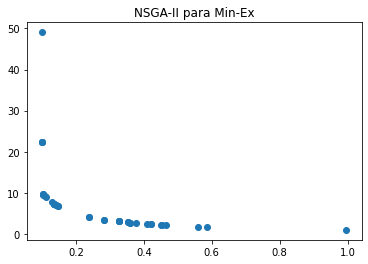

In [ ]:
Fit_fimMinEX = np.zeros((pop,nx), dtype=float)
fitnessMO(Pt2_real, Fit_fimMinEX, pop)

fig1, ax1 = plt.subplots()
ax1.scatter(Fit_fimMinEX[:,0], Fit_fimMinEX[:,1])
plt.title('NSGA-II para Min-Ex')
plt.show()

# NSGA-II em loop: Max-EX

In [ ]:
# Funções essenciais:
def f1(x1):
  return (1.1 - x1)

def f2(x1,x2):
  return (60 - ((1+x2)/x1))

def Dominando(Fit, vRank, pop):  # Versão max
  for i in range(pop):
    Fi1 = Fit[i,0]
    Fi2 = Fit[i,1]
    ni = 0
    for k in range(pop):
      if ((Fi1) < Fit[k,0]):    # Se é pior que um objetivo E
        if ((Fi2) < Fit[k,1]):  # Se é pior que o segundo objetivo
          ni += 1             # É dominada
    vRank[i] = ni + 1         # Atribui um rank

In [ ]:
# Parâmetros AG bin
pop = 40
MaxGen = 400
doupop = int(pop*2)
bits = 40
nx = 2
cromo = bits*nx
Px = 0.90
Pm = 0.02

limXY =  [[0.1, 0],    # X, Y   # Min
          [1  , 5]]             # Max
xmin = limXY[0]
xmax = limXY[1]

fBounds = [[0.1,  0],    # X, Y   # Min
           [1  , 60]]             # Max

# Criação de vetores
vt_bin = np.zeros((pop, cromo), dtype=int)
vt_real = np.zeros((pop, nx), dtype=float)
Fit = np.zeros((pop,2))
vRank = np.zeros((pop,1), dtype=int)

filhos = np.zeros((pop, cromo), dtype=int)
fi_real = np.zeros((pop, nx), dtype=float)
fi_Fit = np.zeros((pop,2))
fi_Rank = np.zeros((pop,1), dtype=int)

Rt_real = np.zeros((doupop, nx), dtype=float)
Rt_Rank = np.zeros((doupop,1), dtype=int)
Fit_Rt = np.zeros((doupop,nx))

Pt2_real = np.zeros((pop, nx), dtype=float)
Pt2_Fit = np.zeros((pop,2))
Pt2_Rank = np.zeros((pop,1), dtype=int)

Qt2 = np.zeros((pop,cromo), dtype=int)
Qt2_real = np.zeros((pop, nx), dtype=float)
Qt2_Fit = np.zeros((pop,2))

In [ ]:
# Parâmetros NSGA
M = 2    # Funções MO

# Inicialização
criarpop(vt_bin, pop, cromo)
print(vt_bin[0:3,:])

# Conversão em Real e Cálculo de Fitness
Bin_xyzw_Real(vt_bin, vt_real, pop, xmin, xmax)
fitnessMO(vt_real, Fit, pop)

print(Fit[0:3,:])


[[1 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0
  0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0
  0 0 1 0 1 1 0 1]
 [1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1
  1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0
  0 0 1 0 0 1 1 1]
 [1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1
  0 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1
  0 1 0 1 1 0 1 1]]
[[ 0.97450307 23.96130492]
 [ 0.22819522 53.73980469]
 [ 0.27118148 53.63271668]]


In [ ]:
# Dominância entre Pais, NSGA-II

Dominando(Fit, vRank, pop)

vRank_s = sortir(vRank, vRank, pop)
vt_real_s = sortir(vt_real, vRank, pop)
vt_bin_s = sortir(vt_bin, vRank, pop)
Fit_s = sortir(Fit, vRank, pop)

vt_bin_s = vt_bin_s.astype(int)
vRank_s = vRank_s.astype(int)

# Número de ranks e membros por rank e Fit compartilhada
memberCount = rankMembers(vRank_s)

Pt1_CrowdSort = crowdSorting(vt_bin_s, Fit_s, vRank_s, memberCount, pop)

### Algoritmo Genético binário

iSelecionados = selecao_NSGA2(vRank_s , Pt1_CrowdSort, pop, 4)

paresRep = criaPares(pop, iSelecionados)
cruzamento(vt_bin_s, paresRep, filhos, Px)      # Crossover
for i in range(pop):                          
  filhos[i,:] = mutacao(filhos[i,:],cromo,Pm)   # Mutação 


<COMEÇA O NSGA-II>


In [ ]:
# while gen < MaxGen:
gen = 0
vetorP = np.copy(vt_bin_s)
vetorQ = np.copy(filhos)

while gen < MaxGen:

# Etapa 1: Unir pais e filhos em uma única população
  Rt = np.concatenate((vetorP, vetorQ))
  Bin_xyzw_Real(Rt, Rt_real, doupop, xmin, xmax)
  fitnessMO(Rt_real, Fit_Rt, doupop)
  Dominando(Fit_Rt, Rt_Rank, doupop)

  Rt_Count = rankMembers(Rt_Rank)
  indices = np.argsort(Rt_Count[:,0],axis=0)
  Rt_Count_s = np.copy(Rt_Count)
  for i in range(len(Rt_Count)):
    Rt_Count_s[i,:] = Rt_Count[int(indices[i])]

  # Definir vetor PT+1 = PT2
  Pt2 = []
  l = 0
  i = 0

  while l <= pop:
    if (l + Rt_Count_s[i,1]  <= pop):
      rank = Rt_Count_s[i,0]
      for k in range(doupop):
        if (Rt_Rank[k] == rank):
          Pt2.append(Rt[k,:])
      i = i + 1
      l = len(Pt2)
    else:
      l1 = l
      l = int(pop*4)

  [crowdRank,crowdLen] = Rt_Count_s[i,:]
  l = l1

  # Crowd Sorting para definir quem entra em Pt2
  # CrowdSorting para o Rank: v2
  crowdVetor = np.zeros((crowdLen,cromo))
  crowdFit = np.zeros((crowdLen,M))
  n = 0
  for k in range(doupop):
      if (Rt_Rank[k] == crowdRank):
        crowdVetor[n,:] = Rt[k,:]
        crowdFit[n,:] = Fit_Rt[k,:]
        n = n + 1

  di = crowdSortRank(crowdFit, crowdLen, M)

  # Pós di calculada: Sortir em ordem decrescente
  # Pegar quantos faltam para topar Pt2

  [di_s,inds] = sortirMaior2(di, crowdLen)
  i = 0
  while l < pop:
    Pt2.append(crowdVetor[inds[i],:])
    l += 1
    i += 1

  
  Pt2v = np.zeros((pop,cromo), dtype=int)
  for i in range(pop):
    Pt2v[i,:] = Pt2[i]

  Pt2_real = np.zeros((pop, nx), dtype=float)
  Pt2_Fit = np.zeros((pop,2))
  Pt2_Rank = np.zeros((pop,1), dtype=int)

  Qt2 = np.zeros((pop,cromo), dtype=int)
  Qt2_real = np.zeros((pop, nx), dtype=float)
  Qt2_Fit = np.zeros((pop,2))

  # Pegando a pop PT2:
  Bin_xyzw_Real(Pt2v, Pt2_real, pop, xmin, xmax)
  fitnessMO(Pt2_real, Pt2_Fit, pop)
  Dominando(Pt2_Fit, Pt2_Rank, pop)

  Pt2_Rank_s = sortir(Pt2_Rank, Pt2_Rank, pop)
  Pt2_real_s = sortir(Pt2_real, Pt2_Rank, pop)
  Pt2v_s = sortir(Pt2v, Pt2_Rank, pop)
  Pt2_Fit_s = sortir(Pt2_Fit, Pt2_Rank, pop)

  Pt2v_s = Pt2v_s.astype(int)
  Pt2_Rank_s = Pt2_Rank_s.astype(int)

  # Número de ranks e membros por rank e Fit compartilhada
  Pt2Count = rankMembers(Pt2_Rank_s)

  # Agora: Cálculo de Crowdsorting em cada rank
  # Gerando um vetor de crowdsort geral

  Pt2_CrowdSort = crowdSorting(Pt2v_s, Pt2_Fit_s, Pt2_Rank_s, Pt2Count, pop)

  # Após calculados: meter o torneio Crowdsorting.
  # Embutido na seleção

  selecao_NSGA2(Pt2_Rank_s , Pt2_CrowdSort, pop, 4)

  # Continuar AG como padrão 
  paresRep = criaPares(pop, iSelecionados)
  cruzamento(Pt2v_s, paresRep, Qt2, Px)      # Crossover
  for i in range(pop):                          
    Qt2[i,:] = mutacao(Qt2[i,:],cromo,Pm)   # Mutação 

  # Nova geração definida: Qt2 e Pt2
  vetorP = np.copy(Pt2v)
  vetorQ = np.copy(Qt2)
  gen = gen + 1

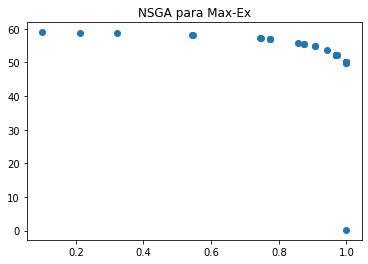

In [ ]:
Fit_fimMaxEX = np.zeros((pop,nx), dtype=float)
fitnessMO(Pt2_real, Fit_fimMaxEX, pop)

fig2, ax2 = plt.subplots()
ax2.scatter(Fit_fimMaxEX[:,0], Fit_fimMaxEX[:,1])
plt.title('NSGA para Max-Ex')
plt.show()

# Imagens finais

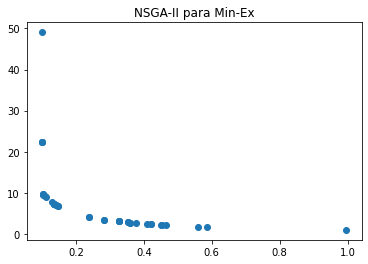

In [ ]:
fig1, ax1 = plt.subplots()
ax1.scatter(Fit_fimMinEX[:,0], Fit_fimMinEX[:,1])
plt.title('NSGA-II para Min-Ex')
plt.show()

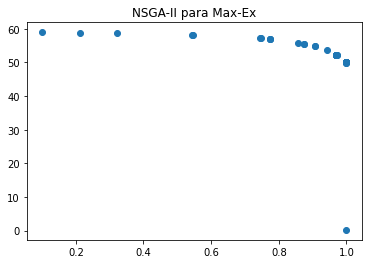

In [ ]:
fig2, ax2 = plt.subplots()
ax2.scatter(Fit_fimMaxEX[:,0], Fit_fimMaxEX[:,1])
plt.title('NSGA-II para Max-Ex')
plt.show()